<a href="https://colab.research.google.com/github/Graur/mipt/blob/dev/job_satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Условие:

Имеются данные по уровню удовлетворенности сотрудников компании (файл job_satisfaction_train.xlsx). Все сотрудники имеют уровень удовлетворенности от 1 до 5 (переменная jobsat).

Требуется построить модель множественной регрессии для предсказания уровня удовлетворенности сотрудников.

Оценить качество построенной модели по различным метрикам (коэффициент детерминации, F-статистика, среднеквадратичная ошибка)

Предсказать недостающие данные в столбце jobsat

1. EDA 

Импортируем все необходимые библиотеки

In [410]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error ,accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             classification_report, r2_score)

%matplotlib inline

Загрузим наш датасет

In [411]:
df = pd.read_excel("/content/sample_data/job_satisfaction_train.xlsx")
df.head()

,age,marital,address,income,inccat,car,carcat,ed,employ,retire,...,callid,callwait,owntv,ownvcr,owncd,ownpda,ownpc,ownfax,news,response
0,55,1,12,72,3,36.2,3,1,23,0,...,0,0,1,1,1,0,0,0,0,1
1,56,0,29,153,4,76.9,3,1,35,0,...,1,1,1,1,1,0,0,0,0,0
2,28,1,9,28,2,13.7,1,3,4,0,...,1,1,1,1,1,1,1,0,1,1
3,24,1,4,26,2,12.5,1,4,0,0,...,0,1,1,1,1,1,1,1,1,1
4,25,0,2,23,1,11.3,1,2,5,0,...,1,0,1,1,1,0,0,0,1,1


Проверим данные

In [412]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       6400 non-null   int64  
 1   marital   6400 non-null   int64  
 2   address   6400 non-null   int64  
 3   income    6400 non-null   int64  
 4   inccat    6400 non-null   int64  
 5   car       6400 non-null   float64
 6   carcat    6400 non-null   int64  
 7   ed        6400 non-null   int64  
 8   employ    6400 non-null   int64  
 9   retire    6400 non-null   int64  
 10  empcat    6400 non-null   int64  
 11  jobsat    5400 non-null   float64
 12  gender    6400 non-null   object 
 13  reside    6400 non-null   int64  
 14  wireless  6400 non-null   int64  
 15  multline  6400 non-null   int64  
 16  voice     6400 non-null   int64  
 17  pager     6400 non-null   int64  
 18  internet  6400 non-null   int64  
 19  callid    6400 non-null   int64  
 20  callwait  6400 non-null   int6

In [413]:
df.shape

(6400, 29)

2. Предобработка данных

Можем наблюдать, что признак пола является категориальным. Его можно легко представить в бинарном виде:

In [414]:
df["gender"].replace('f', 0, inplace=True)
df["gender"].replace('m', 1, inplace=True)

In [415]:
df["gender"].value_counts()

1    3221
0    3179
Name: gender, dtype: int64

In [416]:
df["gender"].unique()

array([0, 1])

In [417]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,6400.0,42.058594,12.289516,18.0,33.0,41.0,51.0,77.0
marital,6400.0,0.496250,0.500025,0.0,0.0,0.0,1.0,1.0
address,6400.0,11.559844,9.938136,0.0,3.0,9.0,17.0,56.0
income,6400.0,69.474844,78.718564,9.0,28.0,45.0,79.0,1116.0
inccat,6400.0,2.528437,1.073835,1.0,2.0,2.0,4.0,4.0
car,6400.0,30.128375,21.926917,4.2,13.9,22.2,39.5,99.9
carcat,6400.0,2.069219,0.799900,1.0,1.0,2.0,3.0,3.0
ed,6400.0,2.587031,1.198760,1.0,2.0,2.0,4.0,5.0
employ,6400.0,10.566250,9.724458,0.0,3.0,8.0,16.0,57.0
retire,6400.0,0.048125,0.214047,0.0,0.0,0.0,0.0,1.0


Построим диаграммы значения всех признаков, для визуального анализа

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f530b3dc2e0>,
      dtype=object)

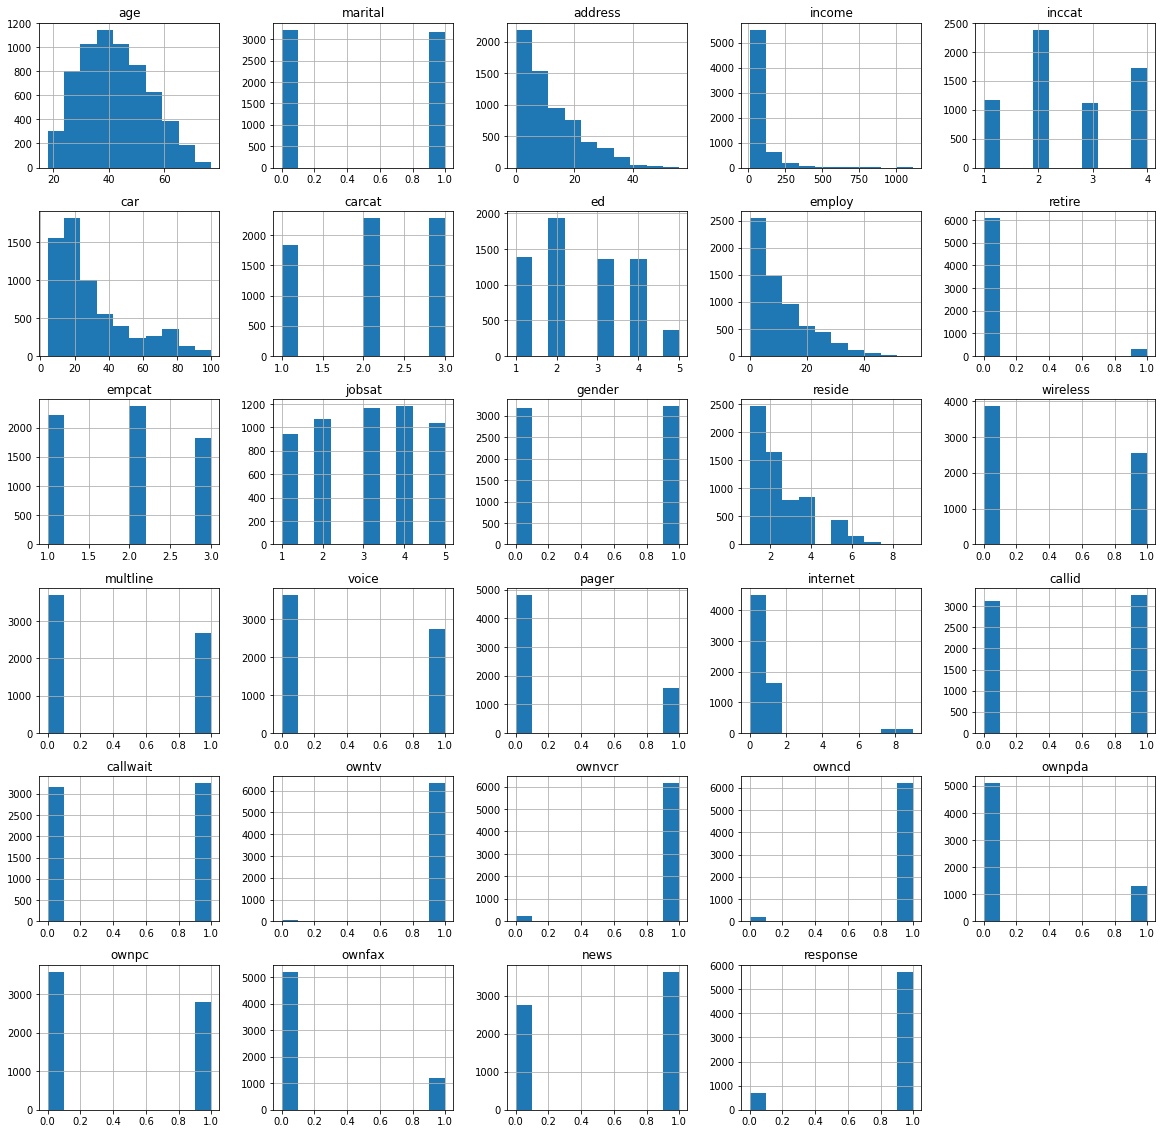

In [418]:
df.hist(figsize=(20,20))

Построим тепловую карту корреляции признаков

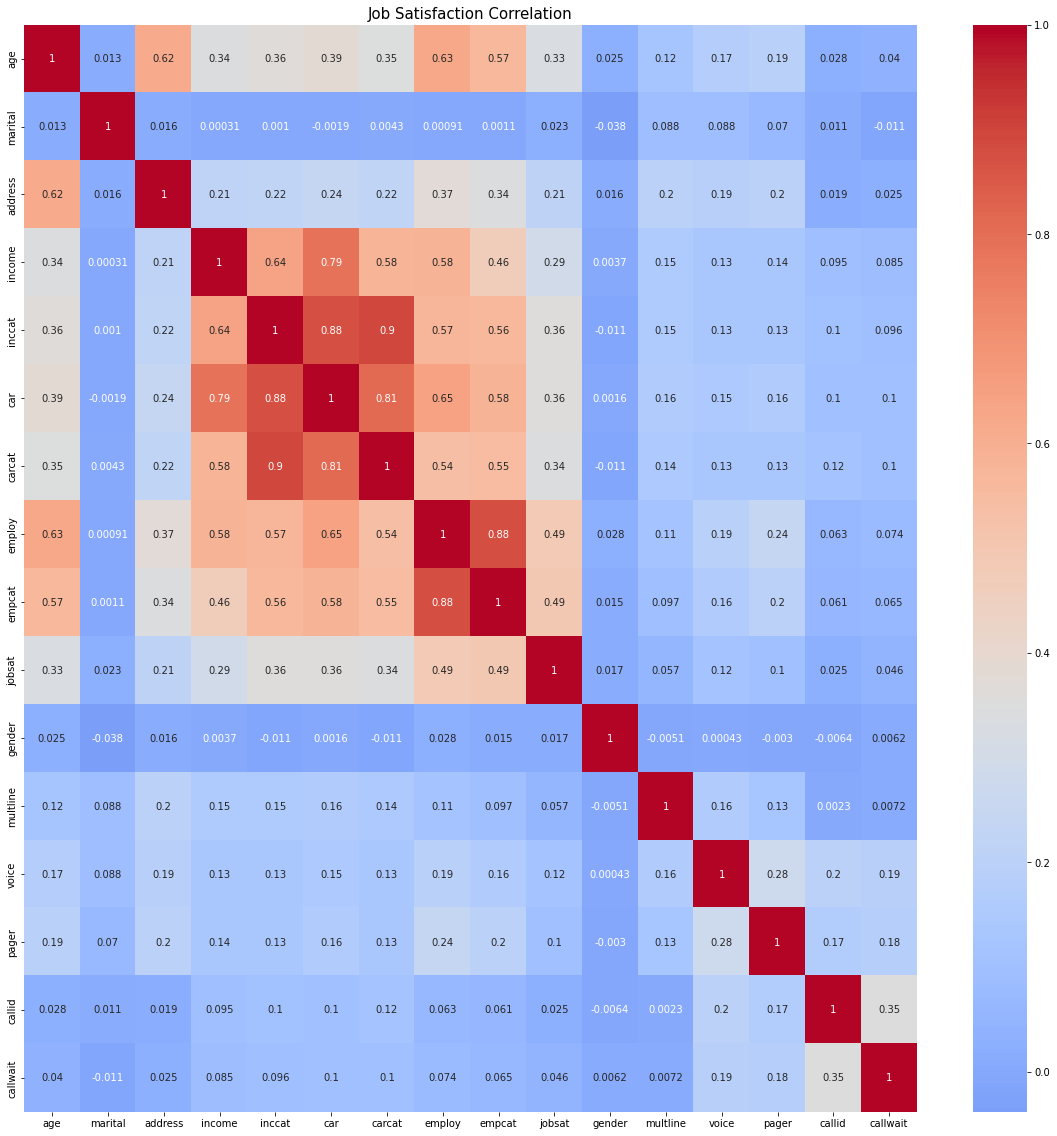

In [419]:
def print_plot():
  c_df = train.copy()
  plt.figure(figsize=(20,20))
  sns.heatmap(c_df.corr(), annot=True, cmap='coolwarm', center = .35)
  plt.title('Job Satisfaction Correlation', fontsize=15)
  
print_plot()

Удалим признаки, которые незначительно влияют на предсказание, ввиду наличия в них превалирующего значения (более 90% из всей выборки значений признаков): retire, ownvcr, owntv, owncd



In [420]:
df.drop(columns=['retire', 'ownvcr', 'owntv', 'owncd'], inplace=True)

Снова проверяем корреляцию

In [421]:
df.corr()['jobsat']

age         0.334635
marital     0.023263
address     0.209449
income      0.290637
inccat      0.356942
car         0.357982
carcat      0.340359
ed         -0.122436
employ      0.486361
empcat      0.493438
jobsat      1.000000
gender      0.017437
reside     -0.077594
wireless   -0.028888
multline    0.057484
voice       0.116363
pager       0.101945
internet   -0.024225
callid      0.025155
callwait    0.046155
ownpda     -0.027227
ownpc      -0.079781
ownfax     -0.022547
news       -0.138258
response   -0.002577
Name: jobsat, dtype: float64

Удаляем признаки с отрицательной корреляцией

In [422]:
df.drop(columns=['ed', 'reside', 'wireless', 'internet', 'ownpda', 'ownpc', 'ownfax', 'news', 'response'], inplace=True)

3. Разделение данных 

In [423]:
train = df.dropna(subset=['jobsat'])
train.head()

,age,marital,address,income,inccat,car,carcat,employ,empcat,jobsat,gender,multline,voice,pager,callid,callwait
0,55,1,12,72,3,36.2,3,23,3,5.0,0,0,1,0,0,0
1,56,0,29,153,4,76.9,3,35,3,4.0,1,0,1,1,1,1
2,28,1,9,28,2,13.7,1,4,1,3.0,0,0,1,0,1,1
3,24,1,4,26,2,12.5,1,0,1,1.0,1,1,1,0,0,1
4,25,0,2,23,1,11.3,1,5,2,2.0,1,0,0,0,1,0


In [424]:
train.shape

(5400, 16)

In [425]:
test = df[df.jobsat.isnull()]
test.head()

,age,marital,address,income,inccat,car,carcat,employ,empcat,jobsat,gender,multline,voice,pager,callid,callwait
5400,66,1,11,10,1,5.0,1,4,1,NaN,1,1,0,0,0,1
5401,51,0,8,237,4,72.8,3,27,3,NaN,0,1,1,0,0,1
5402,47,0,22,193,4,95.1,3,21,3,NaN,0,1,1,0,1,0
5403,55,0,25,86,4,42.1,3,17,3,NaN,0,0,1,1,1,1
5404,51,0,10,34,2,17.2,2,3,1,NaN,1,0,0,0,0,1


In [426]:
test.shape

(1000, 16)

4. Обучение

Делим наши данные на обучающую и тестовую выборку

In [427]:
y = train['jobsat']
X = train.drop('jobsat',axis= 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101)

In [428]:
model = LogisticRegression()
model.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [429]:
predictions = model.predict(X_test)
model.score(X_train, y_train)

0.3457671957671958

5. Оценка качества построенной модели


In [430]:
print("Коэффициент детерминации (r2-score):", r2_score(y_test, predictions))
print('Cреднеквадратичная ошибка: ', mean_squared_error(y_test, predictions))
print("F-статистика:")
print("F1-score (macro):", f1_score(y_test, predictions, average='macro'))
print("F1-score (micro):", f1_score(y_test, predictions, average='micro'))
print("F1-score (weighted):", f1_score(y_test, predictions, average='weighted'))

Коэффициент детерминации (r2-score): -0.22133695517020402
Cреднеквадратичная ошибка:  2.189506172839506
F-статистика:
F1-score (macro): 0.3166524996431671
F1-score (micro): 0.3277777777777778
F1-score (weighted): 0.302164989530997


6. Предсказание недостающих данных

In [431]:
test = test.drop('jobsat',axis= 1)
model.predict(test)

array([2., 5., 5., 4., 1., 1., 1., 4., 1., 5., 1., 5., 4., 1., 5., 2., 1.,
       1., 1., 3., 5., 5., 1., 4., 2., 1., 1., 5., 1., 1., 5., 4., 3., 5.,
       2., 1., 5., 4., 4., 3., 3., 4., 2., 5., 5., 2., 4., 5., 4., 5., 2.,
       5., 3., 1., 1., 5., 2., 1., 1., 1., 1., 1., 1., 1., 4., 1., 1., 1.,
       4., 5., 5., 2., 2., 5., 1., 5., 1., 5., 1., 3., 5., 4., 2., 1., 2.,
       3., 5., 4., 1., 5., 2., 1., 4., 3., 4., 3., 1., 1., 1., 1., 3., 1.,
       1., 2., 1., 1., 5., 2., 1., 1., 2., 3., 1., 1., 1., 2., 1., 5., 3.,
       4., 5., 5., 4., 1., 1., 4., 1., 5., 2., 5., 4., 2., 5., 4., 5., 4.,
       1., 1., 4., 4., 5., 5., 1., 2., 2., 4., 4., 5., 1., 1., 4., 2., 1.,
       1., 2., 5., 5., 3., 5., 3., 5., 3., 5., 1., 5., 1., 1., 5., 1., 1.,
       1., 4., 4., 5., 5., 1., 1., 5., 1., 1., 3., 5., 1., 5., 1., 4., 1.,
       5., 4., 3., 1., 5., 1., 4., 2., 1., 5., 1., 1., 1., 2., 5., 1., 1.,
       1., 5., 5., 5., 3., 2., 4., 1., 1., 4., 3., 5., 3., 5., 1., 1., 5.,
       3., 2., 3., 1., 2.